In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import imghdr
import cv2
import numpy as np
from collections import Counter
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Source and destination directories
srcdir = "/content/drive/MyDrive/Datasets/Cocoa Beans Dataset/train"
#srcdir = "/content/drive/MyDrive/Datasets/Cocoa Beans Dataset/validation"
#dstdir = "/content/drive/MyDrive/Datasets/Augmented/Cocoa Beans[val]"
dstdir = "/content/drive/MyDrive/Datasets/Augmented/Cocoa Beans[train]"

In [ ]:
def print_directory_structure(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for file in files:
            print(f"{sub_indent}{file}")

In [ ]:
def find_dominant_image_size(srcdir):
    """
    Finds the dominant image size in each subdirectory of srcdir.

    :param srcdir: Source directory containing subdirectories with images.
    :return: A dictionary mapping each subdirectory to its dominant image size.
    """
    dominant_sizes = {}

    # Iterate through each subdirectory
    for subdir in os.listdir(srcdir):
        subdir_path = os.path.join(srcdir, subdir)
        if os.path.isdir(subdir_path):
            image_sizes = []

            # Iterate through images in the subdirectory
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                if os.path.isfile(file_path):
                    # Read image and get its size
                    img = cv2.imread(file_path)
                    if img is not None:
                        height, width, _ = img.shape
                        image_sizes.append((width, height))

            # Calculate dominant image size
            if image_sizes:
                dominant_size = Counter(image_sizes).most_common(1)[0][0]
                dominant_sizes[subdir] = dominant_size

    return dominant_sizes

In [ ]:
def average_dominant_size(dominant_sizes):
    # Extract the sizes from the dictionary
    sizes = list(dominant_sizes.values())

    # Calculate the average dominant size
    if sizes:
        average_size = tuple(map(lambda x: sum(x) // len(sizes), zip(*sizes)))
    else:
        average_size = None

    return average_size

In [ ]:
def print_directory_structure(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for file in files:
            print(f"{sub_indent}{file}")

In [ ]:
def calculate_class_distribution(src_dir):
    class_distribution = {}
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')  # Define image file extensions

    for root, dirs, files in os.walk(src_dir):
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            if os.path.isdir(subdir_path):
                num_images = 0
                for file in os.listdir(subdir_path):
                    if file.lower().endswith(image_extensions):
                        num_images += 1
                if num_images > 0:
                    #print(f"Found {num_images} images in class {subdir}")  # Debugging print statement
                    class_distribution[subdir] = num_images

    #print(f'Class Distribution:\n{class_distribution}')
    return class_distribution

In [ ]:
def calculate_image_size_distribution(src_dir):
    image_sizes = []
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    width, height = img.size
                    image_sizes.append((width, height))
    #print(f'Image Sizes:\n{image_sizes}')
    return image_sizes

In [ ]:
def plot_analysis(class_distribution, image_sizes, save_dir, file_description):
    # Class Distribution Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(save_dir, f'{file_description} class distribution (Train).png'))
    plt.show()
    plt.close()

    # Image Size Histogram
    width_height = np.array(image_sizes)
    plt.figure(figsize=(10, 6))
    plt.hist(width_height[:, 0], bins=30, alpha=0.5, label='width')
    plt.hist(width_height[:, 1], bins=30, alpha=0.5, label='height')
    plt.xlabel('Size')
    plt.ylabel('Frequency')
    plt.title('Image Size Distribution')
    plt.legend()
    plt.savefig(os.path.join(save_dir, f'{file_description} image size distribution (Train).png'))
    plt.show
    plt.close()

In [ ]:
def plot_sample_image_from_each_class(src_dir, save_dir, file_description, class_distribution):
    # Initialize a figure
    plt.figure(figsize=(15, 15))  # Adjust the size as needed
    plt.suptitle('Sample Image from Each Class (Train set)', fontsize=16)

    # Assuming a maximum of 6 classes for this layout
    num_classes = 6
    for i, (class_name, _) in enumerate(class_distribution.items()):
        # Construct the path to the class directory
        class_dir_path = os.path.join(src_dir, class_name)
        if os.path.isdir(class_dir_path):
            # Attempt to open and display the first image found in the class directory
            for file in os.listdir(class_dir_path):
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    img_path = os.path.join(class_dir_path, file)
                    if os.path.isfile(img_path):
                        img = Image.open(img_path)
                        plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns layout
                        plt.imshow(img)
                        plt.title(class_name)
                        plt.axis('off')
                        break  # Stop after finding and plotting the first image
            else:
                print(f"No image found for class {class_name}")
        else:
            print(f"Directory {class_name} does not exist in {src_dir}")

    # Save the figure to the specified save directory
    plt.savefig(os.path.join(save_dir, f'{file_description}_sample_images (Train).png'))
    plt.show()
    plt.close()


In [ ]:
def analyze_dataset(src_dir, save_dir, file_description):
    class_distribution = calculate_class_distribution(src_dir)
    image_sizes = calculate_image_size_distribution(src_dir)

    num_classes = len(class_distribution)
    num_images = sum(class_distribution.values())

    # Check if image_sizes is not empty before calculating the average
    if image_sizes:
        avg_width, avg_height = np.mean(image_sizes, axis=0)
        avg_image_size = (avg_width, avg_height)
    else:
        avg_image_size = (0, 0)  # Default values for empty image_sizes

    # Save class distribution to a text file
    class_dist_file = os.path.join(save_dir, f'Train {file_description} analysis.txt')
    with open(class_dist_file, 'w') as f:
        f.write("Class Distribution:\n")
        for class_name, num_images in class_distribution.items():
            f.write(f"- {class_name}: {num_images} images\n")

    # Check if there are any images to analyze
    if image_sizes:
        avg_width, avg_height = np.mean(image_sizes, axis=0)
        avg_image_size = (avg_width, avg_height)
        # Write the average image size if there are images to analyze
        with open(class_dist_file, 'a') as f:  # Append mode to add to the existing file
            f.write(f"Average Image Size: {avg_image_size[0]:.2f} x {avg_image_size[1]:.2f} pixels\n")
    else:
        # If there are no images, indicate that in the file
        with open(class_dist_file, 'a') as f:  # Append mode to add to the existing file
            f.write("Image Size Distribution:\n")
            f.write("No images found to calculate average size.\n")

    # Plot sample images from each class
    plot_sample_image_from_each_class(src_dir, save_dir, file_description, class_distribution)

    return class_distribution, image_sizes


In [ ]:
def check_class_imbalance(src_dir):
    total_count = 0
    class_counts = {}

    # Get all subdirectories in the source directory
    subdirectories = []
    for subdir in os.listdir(src_dir):
        subdir_path = os.path.join(src_dir, subdir)
        if os.path.isdir(subdir_path):
            for sub_subdir in os.listdir(subdir_path):
                sub_subdir_path = os.path.join(subdir_path, sub_subdir)
                if os.path.isdir(sub_subdir_path):
                    subdirectories.append(sub_subdir)

    # Iterate over each subdirectory
    for subdir in subdirectories:
        count = 0
        # Iterate over each directory in src_dir
        for directory in os.listdir(src_dir):
            dir_path = os.path.join(src_dir, directory)
            # Check if the subdirectory exists in the current directory
            if os.path.isdir(os.path.join(dir_path, subdir)):
                # Count the samples in the subdirectory
                num_samples = len(os.listdir(os.path.join(dir_path, subdir)))
                count += num_samples
        class_counts[subdir] = count

    total_count = sum(class_counts.values())
    return total_count, class_counts

In [ ]:
def find_class_with_max_samples(src_dir):
    max_samples = 0
    max_class = ""

    # Dictionary to store sample counts for each sub_subdirectory name
    sub_subdir_counts = defaultdict(int)

    # Iterate over subdirectories in src_dir
    for subdir in os.listdir(src_dir):
        subdir_path = os.path.join(src_dir, subdir)
        if os.path.isdir(subdir_path):
            # Iterate over sub-subdirectories in each subdirectory
            for sub_subdir in os.listdir(subdir_path):
                sub_subdir_path = os.path.join(subdir_path, sub_subdir)
                if os.path.isdir(sub_subdir_path):
                    # Count the number of samples in each sub-subdirectory
                    sub_subdir_counts[sub_subdir] += len(os.listdir(sub_subdir_path))

    # Find the sub_subdirectory with the highest total sample count
    for sub_subdir, count in sub_subdir_counts.items():
        if count > max_samples:
            max_samples = count
            max_class = sub_subdir

    print(f'{max_class} has the highest number of samples with {max_samples}.')
    return max_class, max_samples

In [ ]:
# Function to create subdirectories recursively
def create_subdirectories(src_dir, dst_dir):
    for root, dirs, _ in os.walk(src_dir):
        rel_path = os.path.relpath(root, src_dir)
        dst_path = os.path.join(dst_dir, rel_path)
        for dir_name in dirs:
            new_dir_path = os.path.join(dst_path, dir_name)
            if not os.path.exists(new_dir_path):
                os.makedirs(new_dir_path)

In [ ]:
def augment_to_balance_classes(src_dir, dst_dir, config, image_size, batch_size):
    # Create the ImageDataGenerator
    Augment_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=config['rotation_range'],
        width_shift_range=config['width_shift_range'],
        height_shift_range=config['height_shift_range'],
        zoom_range=config['zoom_range'],
        horizontal_flip=config['horizontal_flip'],
        fill_mode=config['fill_mode']
    )

    # Iterate over each subdirectory in dst_dir
    for subdir in os.listdir(dst_dir):
        dst_subdir_path = os.path.join(dst_dir, subdir)
        if os.path.isdir(dst_subdir_path):
            # Find the corresponding subdirectory in src_dir
            src_subdir_path = os.path.join(src_dir, subdir)
            if os.path.isdir(src_subdir_path):
                # Load images from the subdirectory
                images_filenames = [os.path.join(src_subdir_path, fname) for fname in os.listdir(src_subdir_path)]
                images = [tf.keras.preprocessing.image.load_img(fname, target_size=image_size) for fname in images_filenames]
                images = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in images])

                # Calculate the number of samples needed to reach 400
                current_num_samples = len(images)
                remaining_samples_needed = max(0, 400 - current_num_samples)

                if remaining_samples_needed > 0:
                    # Create a data generator for augmentation
                    augmented_generator = Augment_generator.flow(images,
                                            batch_size=batch_size,
                                            save_to_dir=dst_subdir_path,
                                            save_prefix='augmented',
                                            save_format='jpeg',
                                            shuffle=True)

                    # Generate augmented images
                    num_batches_to_generate = int(np.ceil(remaining_samples_needed / batch_size))
                    remaining_samples = remaining_samples_needed

                    for _ in range(num_batches_to_generate):
                        if remaining_samples > batch_size:
                            augmented_images_batch = next(augmented_generator)
                            remaining_samples -= batch_size
                        else:
                            augmented_images_batch = next(augmented_generator)[:remaining_samples]
                            remaining_samples = 0

                        # Save the augmented images
                        for i, img in enumerate(augmented_images_batch):
                            if remaining_samples > 0:
                                save_path = os.path.join(dst_subdir_path, f'augmented_{i}.jpg')
                                tf.keras.preprocessing.image.save_img(save_path, img)
                                remaining_samples -= 1

In [ ]:
def count_images_in_subdirectories(path):
    """
    Counts the number of images in each subdirectory of the given path.

    :param path: The path to count images in subdirectories of.
    """
    # Check if the path exists
    if not os.path.exists(path):
        print(f"The path {path} does not exist.")
        return

    # List all items in the directory
    items = os.listdir(path)

    # Filter out subdirectories
    subdirectories = [item for item in items if os.path.isdir(os.path.join(path, item))]

    # Iterate through subdirectories and count images
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(path, subdirectory)
        image_count = sum(1 for file in os.listdir(subdirectory_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')))
        print(f"Subdirectory: {subdirectory}, Image count: {image_count}")

In [ ]:
def count_and_adjust_images_in_subdirectories(path, target_count=350):
    """
    Counts the number of images in each subdirectory of the given path.
    If the count exceeds the target count, deletes images with 'augmented' in their names.

    :param path: The path to count images in subdirectories of.
    :param target_count: The target count of images in each subdirectory.
    """
    # Check if the path exists
    if not os.path.exists(path):
        print(f"The path {path} does not exist.")
        return

    # List all items in the directory
    items = os.listdir(path)

    # Filter out subdirectories
    subdirectories = [item for item in items if os.path.isdir(os.path.join(path, item))]

    # Iterate through subdirectories
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(path, subdirectory)
        image_files = [file for file in os.listdir(subdirectory_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        image_count = len(image_files)

        # If image count exceeds the target count
        if image_count > target_count:
            # Sort the image files to prioritize deletion of augmented images
            image_files.sort()

            # Calculate number of images to delete
            images_to_delete = image_count - target_count

            # Delete images with 'augmented' in their names
            for file in image_files:
                if 'augmented' in file.lower():
                    os.remove(os.path.join(subdirectory_path, file))
                    images_to_delete -= 1
                    if images_to_delete <= 0:
                        break

        # Update image count after adjustment
        adjusted_image_count = len([file for file in os.listdir(subdirectory_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
        print(f"Subdirectory: {subdirectory}, Adjusted Image count: {adjusted_image_count}")


# Parameters

In [ ]:
# Augmentation parameters
config = {
    'rotation_range': 40,
    'width_shift_range': 0.02,
    'height_shift_range': 0.02,
    'zoom_range': 0.01,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

# 1. Data Analysis

In [ ]:
print_directory_structure(srcdir)

train/
    Fermented_Cocoa/
        FR01_41.jpg
        FR01_60.jpg
        FR01_12.jpg
        FR01_19.jpg
        FR01_29.jpg
        FR01_51.jpg
        FR01_25.jpg
        FR01_31.jpg
        FR01_24.jpg
        FR01_10.jpg
        FR01_01.jpg
        FR01_16.jpg
        FR01_62.jpg
        FR01_65.jpg
        FR01_47.jpg
        FR01_56.jpg
        FR01_58.jpg
        FR01_20.jpg
        FR01_38.jpg
        FR01_40.jpg
        FR01_33.jpg
        FR01_54.jpg
        FR01_04.jpg
        FR01_30.jpg
        FR01_59.jpg
        FR01_28.jpg
        FR01_44.jpg
        FR01_43.jpg
        FR01_18.jpg
        FR01_49.jpg
        FR01_08.jpg
        FR01_06.jpg
        FR01_42.jpg
        FR01_27.jpg
        FR01_53.jpg
        FR01_11.jpg
        FR01_50.jpg
        FR01_23.jpg
        FR01_26.jpg
        FR01_03.jpg
        FR01_39.jpg
        FR01_36.jpg
        FR01_14.jpg
        FR01_21.jpg
        FR01_09.jpg
        FR01_07.jpg
        FR01_63.jpg
        FR01_17.jpg
        FR01

## a. Determining optimum image size

In [ ]:
# Find dominant image sizes
dominant_sizes = find_dominant_image_size(srcdir)
print("Dominant image sizes in each subdirectory:")
for subdir, size in dominant_sizes.items():
    print(f"Subdirectory: {subdir}, Dominant Size: {size}")

# Calculate average dominant size
average_size = average_dominant_size(dominant_sizes)
print("\nAverage dominant image size:", average_size)

# Use the first dominant size found for augmentation
if dominant_sizes:
    first_subdir = next(iter(dominant_sizes))
    image_size = dominant_sizes[first_subdir]


print("\nChosen image size for augmentation:", image_size)

Dominant image sizes in each subdirectory:
Subdirectory: Fermented_Cocoa, Dominant Size: (114, 114)
Subdirectory: Whole_Beans_Cocoa, Dominant Size: (121, 121)
Subdirectory: Moldy_Cocoa, Dominant Size: (110, 110)
Subdirectory: Unfermented_Cocoa, Dominant Size: (115, 115)
Subdirectory: Broken_Beans_Cocoa, Dominant Size: (79, 79)
Subdirectory: Bean_Fraction_Cocoa, Dominant Size: (55, 55)

Average dominant image size: (99, 99)

Chosen image size for augmentation: (114, 114)


In [ ]:
# Parameters
batch_size = 32
image_size = image_size

In [ ]:
save_dir = '/content/drive/MyDrive/Results and output/Cocoa Beans Classification/Data Pipeline'

## b. Analyzing images

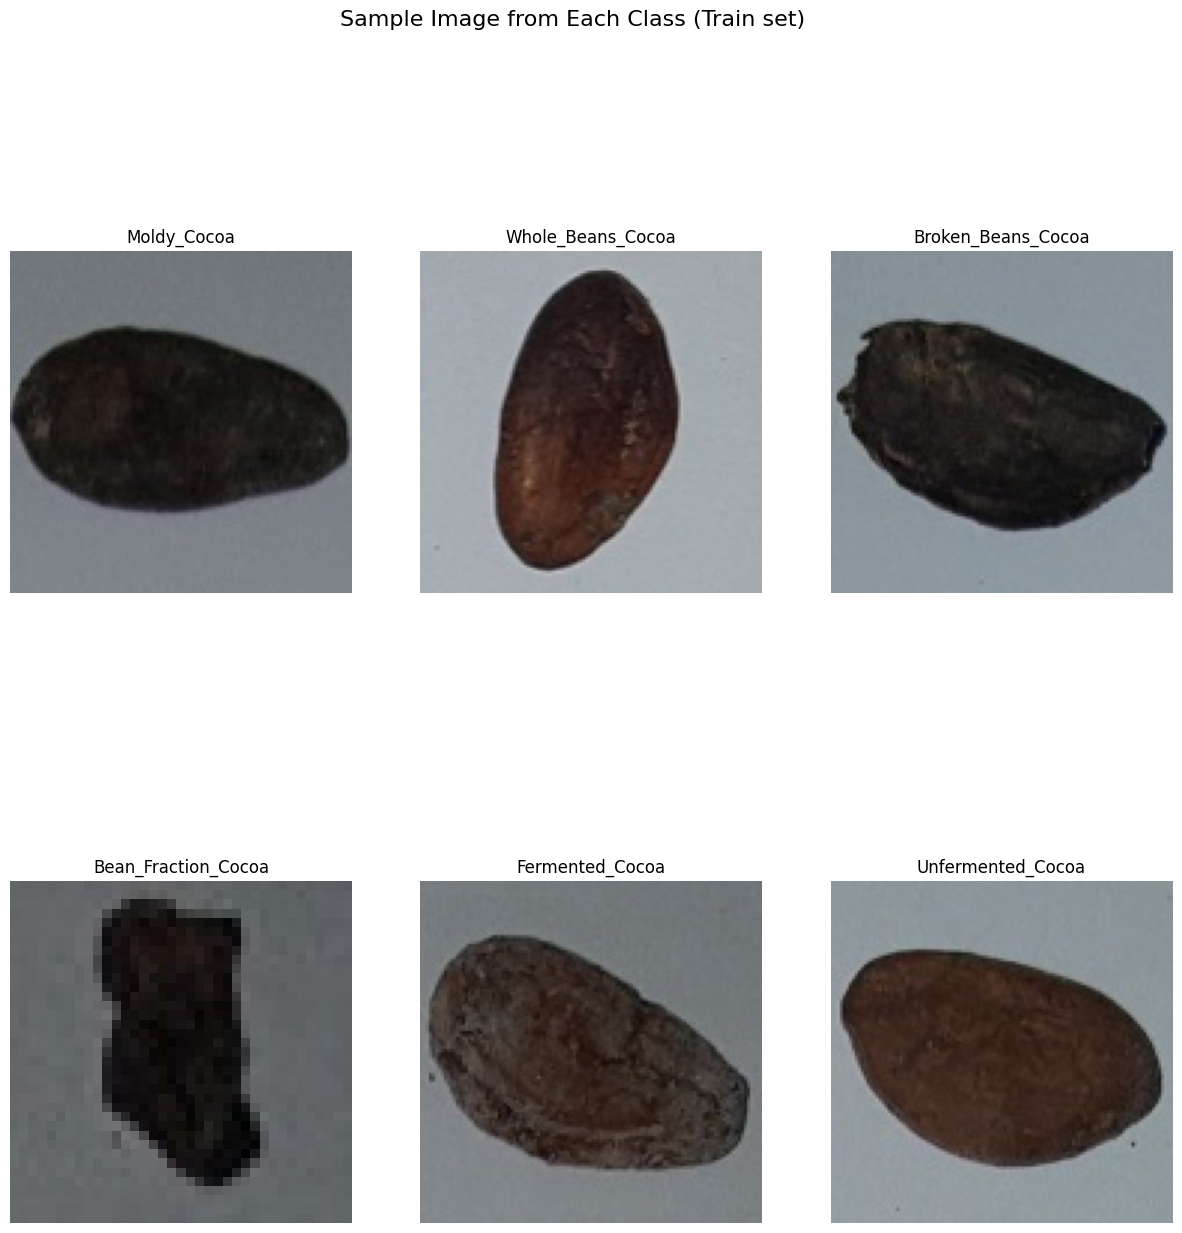

In [ ]:
descr_aug = 'Augmented'
dst_class_distribution, dst_image_sizes = analyze_dataset(dstdir, save_dir, descr_aug)

In [ ]:
plot_analysis(dst_class_distribution, dst_image_sizes, save_dir, descr_aug)

In [ ]:
# Define the directory where you want to save the analyses and plots
descr = "Original"

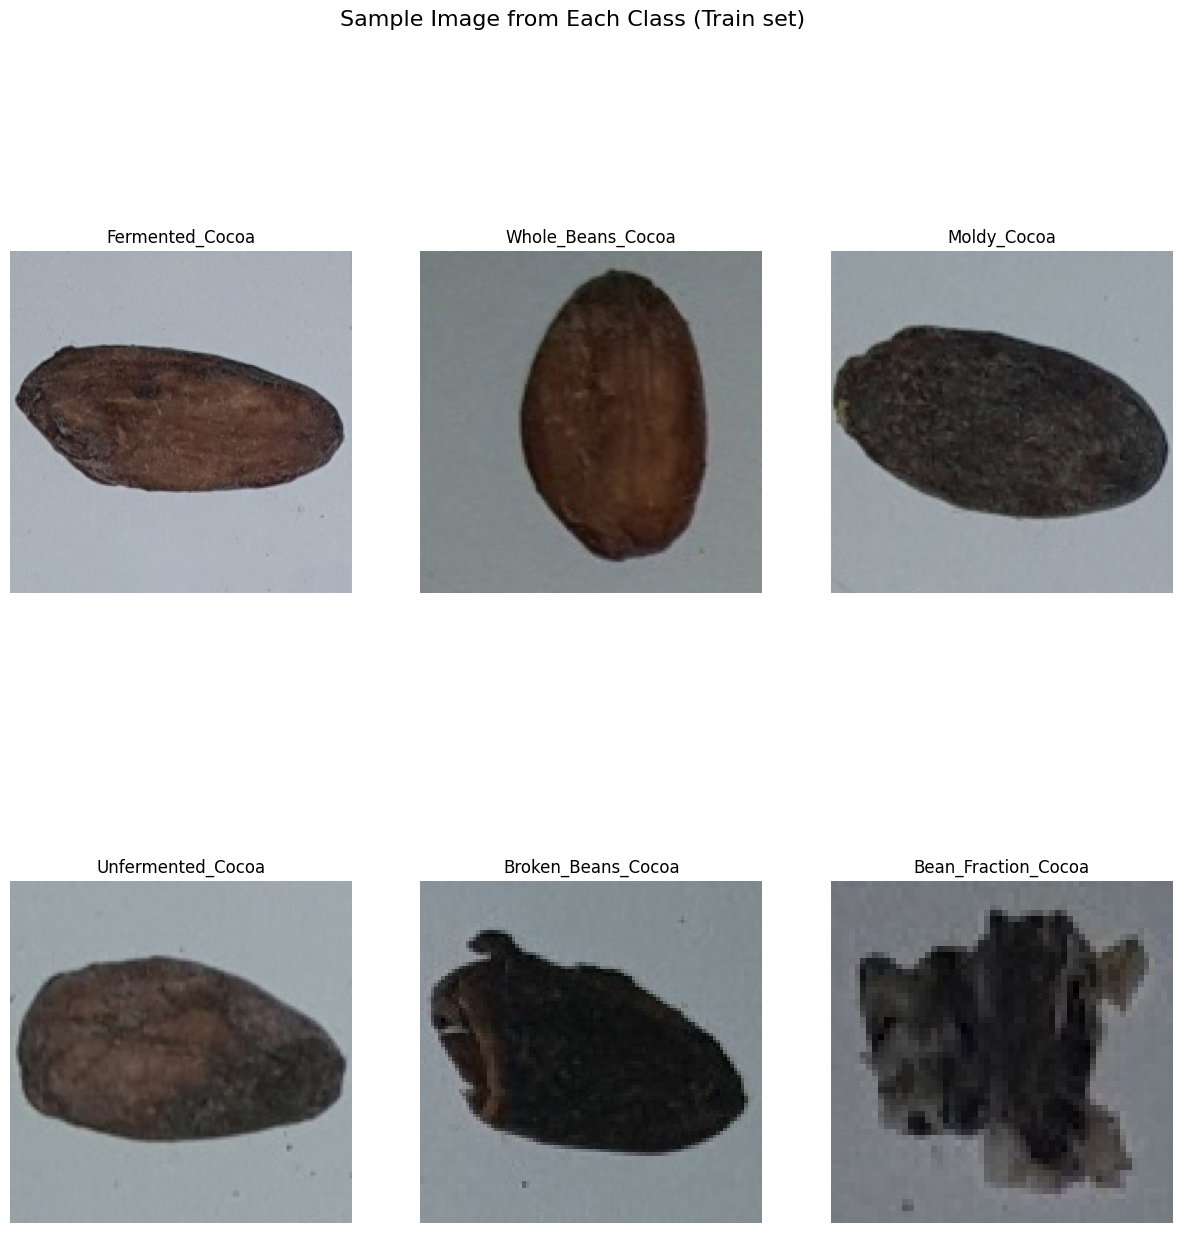

In [ ]:
src_class_distribution, src_image_sizes = analyze_dataset(srcdir, save_dir, descr)

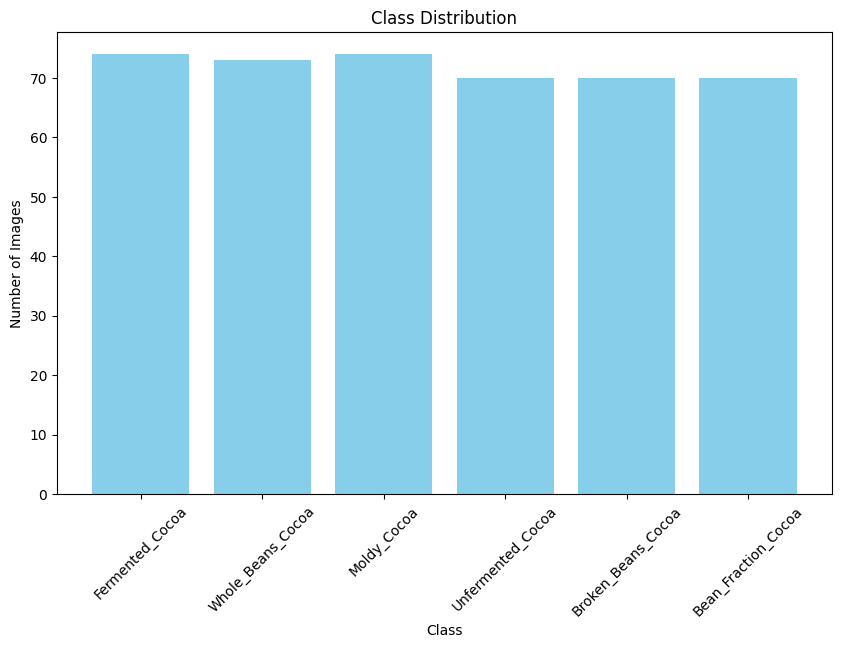

In [ ]:
plot_analysis(src_class_distribution, src_image_sizes, save_dir, descr)

# 2. Data Preprocessing

In [ ]:
# Check class imbalances in the source directory
total_samples, class_imbalances = check_class_imbalance(srcdir)
print("Total Samples:", total_samples)
print("Class Imbalances:")
for class_name, count in class_imbalances.items():
    print(f"{class_name}: {count} samples")

Total Samples: 0
Class Imbalances:


In [ ]:
# Find the class with the maximum number of samples
max_class, max_samples = find_class_with_max_samples(srcdir)

 has the highest number of samples with 0.


In [ ]:
# Create the destination directory if it doesn't exist
if not os.path.exists(dstdir):
    os.makedirs(dstdir)

## a. Data Augmentation

In [ ]:
# Augment classes to balance the number of samples
augment_to_balance_classes(srcdir, dstdir, config, image_size, batch_size)

print("Augmentation completed.")

Augmentation completed.


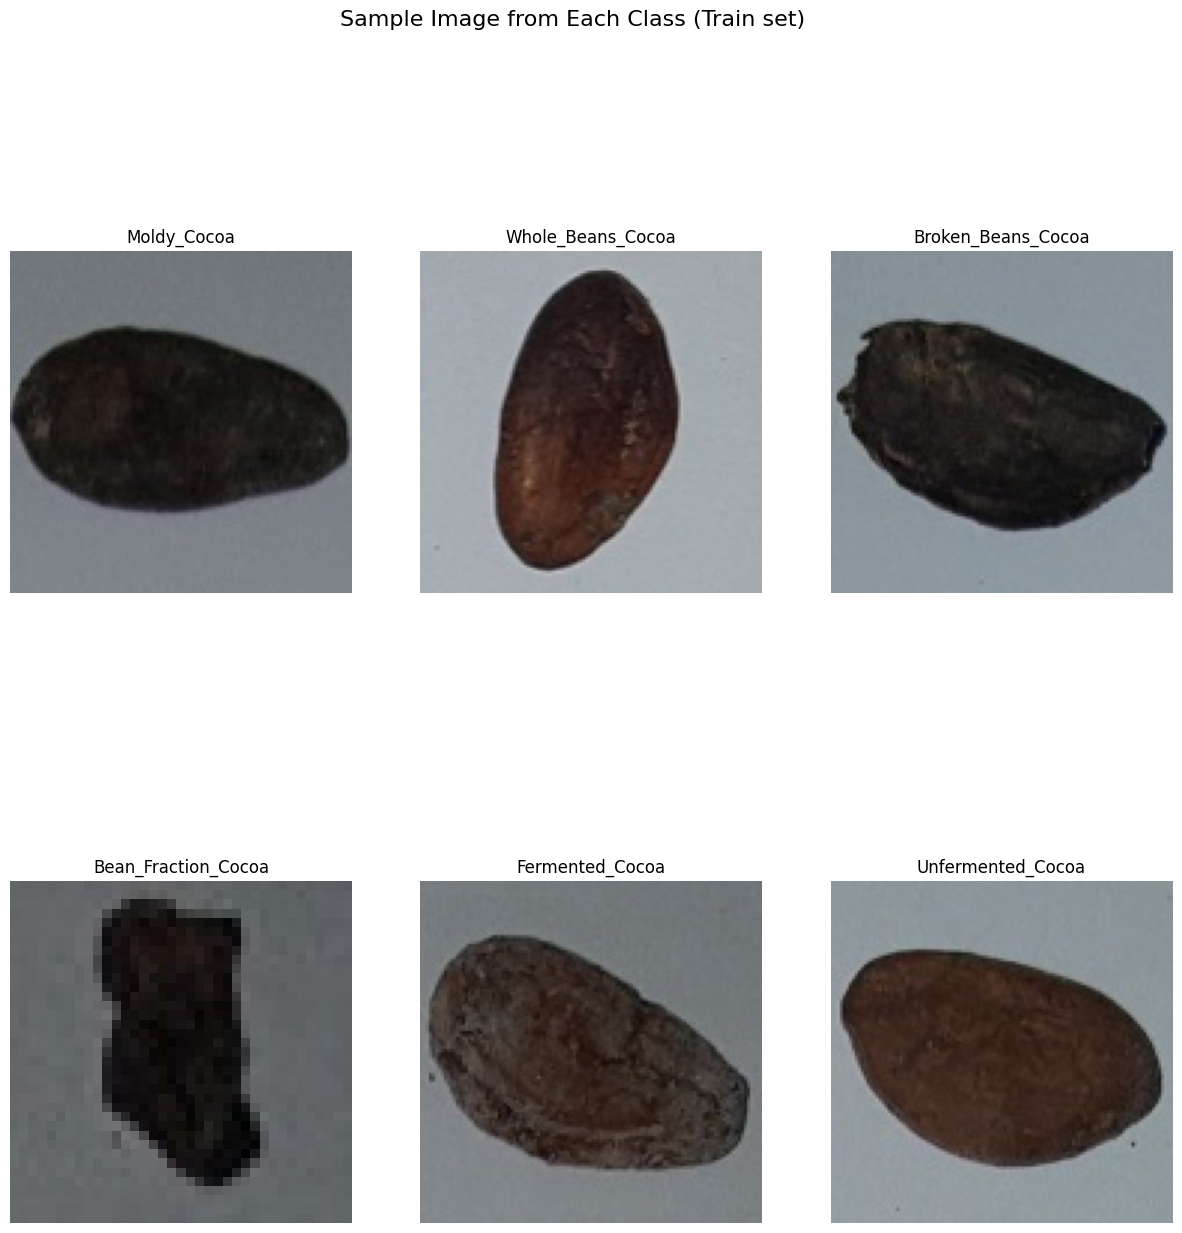

In [ ]:
descr_aug = 'Augmented'
dst_class_distribution, dst_image_sizes = analyze_dataset(dstdir, save_dir, descr_aug)

## b. Post Augmentation Analysis

In [ ]:
path = dstdir
count_images_in_subdirectories(path)

In [ ]:
count_and_adjust_images_in_subdirectories(dstdir)v

Subdirectory: Moldy_Cocoa, Adjusted Image count: 350
Subdirectory: Whole_Beans_Cocoa, Adjusted Image count: 350
Subdirectory: Broken_Beans_Cocoa, Adjusted Image count: 350
Subdirectory: Bean_Fraction_Cocoa, Adjusted Image count: 350
Subdirectory: Fermented_Cocoa, Adjusted Image count: 350
Subdirectory: Unfermented_Cocoa, Adjusted Image count: 350


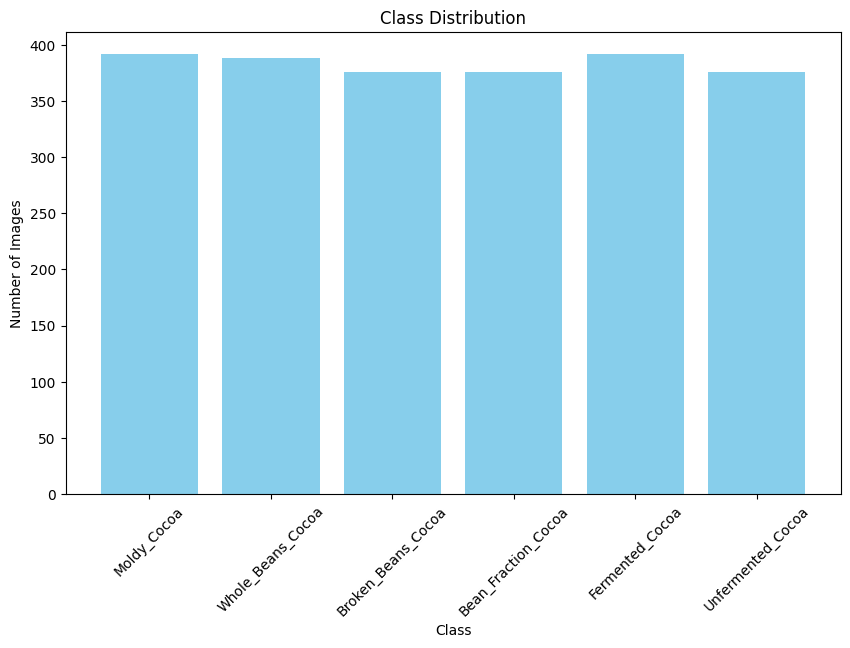

In [ ]:
plot_analysis(dst_class_distribution, dst_image_sizes, save_dir, descr_aug)